# 1. Download email
- Login and Scraping data from mailbox and save data as a datafram whose columns are **[email,name,title,content,date,spam].**

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"       
import time 
import requests 
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as colors
from bs4 import BeautifulSoup     
from urllib.request import urlopen
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [658]:
#Login Stevens
def login(driver,user,pwd, user_stevens='zwang173'): 
    driver.get('https://gmail.com/')
    driver.find_element_by_id('identifierId').send_keys(user)
    driver.find_element_by_xpath("//div[@id='identifierNext']/content/span").click()
    driver.switch_to.window(driver.window_handles[0])
    time.sleep(2)
    driver.find_element_by_id("username").send_keys(user_stevens)
    driver.find_element_by_id("password").send_keys(pwd)
    driver.find_element_by_name("_eventId_proceed").click()
    driver.switch_to.window(driver.window_handles[0])
    time.sleep(2)
    driver.find_element_by_xpath("//div[@id='view_container']/descendant::content/span").click()
    driver.switch_to.window(driver.window_handles[0])
    return driver

In [4]:
#Scraping data from mailbox
def get_data(driver,spam=False):
    time.sleep(1)
    row = []
    n = 0
    
    if spam == True:
        time.sleep(3)
        driver.find_element_by_xpath("//div[@class='wT']/div[@class='n6']/span/span").click()
        driver.find_element_by_xpath("//div[@class='TN bzz aHS-bnv']/div/span").click()
        driver.switch_to.window(driver.window_handles[0])
        time.sleep(2)
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        tbody = soup.select('div#:1 table.F.cf.zt tr')
        total_num = int([i.get_text() for i in soup.select('div#:zm span.ts')][-1].replace(',',''))
        page_number = int(total_num / 50)
        time.sleep(2)
    else:
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        tbody = soup.select('div#:1 table.F.cf.zt tr')
        total_num = int([i.get_text() for i in soup.select('div#:hh span.ts')][-1].replace(',',''))
        page_number = int(total_num / 50)
        time.sleep(2)

    while n <= page_number: 
        lst = []
        tbody = soup.select('div#:1 table.F.cf.zt tr')
        for tr in tbody:
            name = None
            email= None
            title = None
            date = None
            
            td_sender = tr.select('td.yX.xY span.bA4')[0].select_one('span')
            if td_sender != []:
                email = td_sender.attrs['email']
                name = td_sender.attrs['name']           

            td_title = tr.select('td.xY.a4W span.bog')
            if td_title != []:
                title = td_title[0].get_text()

            td_content = tr.select('td.xY.a4W span.y2')
            if td_content != []:
                content = td_content[0].get_text()
            
            td_date = tr.select('td.xW.xY span')
            if td_date != []:
                date = td_date[0].get_text()   
            
            lst.append((email,name,title,content,date))
        
        if n == 0:
            row = lst[-50:]
        elif n == page_number:
            row += lst[-(total_num-page_number*50):] 
        else:
            row += lst[-50:] 
              
        id_click = soup.select('div.ar5.J-J5-Ji span.Di div')[-1].attrs['id']
        time.sleep(2)
        
        if n < page_number:
            driver.find_element_by_id(id_click).click()
            driver.switch_to.window(driver.window_handles[0])
            time.sleep(1)
            soup = BeautifulSoup(driver.page_source, 'html.parser')
        
        n += 1
        time.sleep(1)
    
    driver.quit()
    return row

In [5]:
#Get all text content of each email
def get_content(driver, num, spam=False):
    n = 0;
    lst = []
    lst_num = []
    if spam == True:
        time.sleep(3)
        driver.find_element_by_xpath("//div[@class='wT']/div[@class='n6']/span/span").click()
        driver.find_element_by_xpath("//div[@class='TN bzz aHS-bnv']/div/span").click()
        driver.switch_to.window(driver.window_handles[0])
        time.sleep(2)
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        total_num = int([i.get_text() for i in soup.select('div#:zm span.ts')][-1].replace(',',''))
        driver.find_element_by_xpath("//table[@id=':k5']/tbody/tr").click()
    else:
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        total_num = int([i.get_text() for i in soup.select('div#:hh span.ts')][-1].replace(',',''))
        driver.find_element_by_xpath("//table[@id=':20']/tbody/tr").click()  
        time.sleep(2)    
        
    driver.switch_to.window(driver.window_handles[0])
   
    while n < num:       
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        lst_num.append(int([i.get_text() for i in soup.select('div.h0 span.ts')][0].replace(',','')))
        lst.append(soup.select('div.G3.G2 div.gs div.ii.gt')[0].get_text())
        if total_num <= n + 1:
            break
        while(True):
            try:            
                driver.find_element_by_xpath("//div[@class='T-I J-J5-Ji adg T-I-awG T-I-ax7 T-I-Js-Gs L3']").click()             
                break
            except:
                continue   
        n += 1
        time.sleep(1)
    
    driver.quit()
    return lst,lst_num

In [12]:
#spam
driver = login(webdriver.Chrome(),'zwang173@stevens.edu','Kmj19950711*')
data_s = get_data(driver,spam=True)
data_s_copy = data_s
driver = login(webdriver.Chrome(),'zwang173@stevens.edu','Kmj19950711*')
driver.switch_to.window(driver.window_handles[0])
data_content_s = get_content(driver, 199, spam=True)
data_content_s_copy = data_content_s

In [51]:
#ham
driver = login(webdriver.Chrome(),'zwang173@stevens.edu','Kmj19950711*')
data_h = get_data(driver,spam=False)
data_h_copy = data_h
driver = login(webdriver.Chrome(),'zwang173@stevens.edu','Kmj19950711*')
driver.switch_to.window(driver.window_handles[0])
data_content_h = get_content(driver, 1000, spam=False)
data_content_h_copy = data_content_h 

In [87]:
df_content_h = pd.DataFrame(data_content_h[0],columns = ['content'])
duplicate = list(set([i for i in data_content_h[1] if data_content_h[1].count(i) > 1]))
df_content_h = df_content_h.drop(duplicate)
df_h = pd.DataFrame(data_h,columns = ['address','name','title','content','date'])
df_h['spam'] = np.zeros(len(data_h),int)
df_h.index = np.arange(len(df_h))
df_h.index.name = 'index'
df_h = df_h.drop(duplicate)
id = [i for i,j in zip(df_content_h.index,df_h.index) if i == j]
df_h = df_h.loc[id,:]
df_h.content = df_content_h.content 

In [108]:
df_content_s = pd.DataFrame(data_content_s[0],columns = ['content'])
duplicate = list(set([i for i in data_content_s[1] if data_content_s[1].count(i) > 1]))
df_content_s = df_content_s.drop(duplicate)
df_s = pd.DataFrame(data_s,columns = ['address','name','title','content','date'])
df_s['spam'] = np.ones(len(data_s),int)
df_s.index = np.arange(len(df_s))
df_s.index.name = 'index'
df_s = df_s.drop(duplicate)
id = [i for i,j in zip(df_content_s.index,df_s.index) if i == j]
df_s = df_s.loc[id,:]
df_s.content = df_content_s.content    

In [110]:
#merge dataset
df = df_h.append(df_s, ignore_index=True)
df.index = np.arange(len(df))
df.index.name = 'index'

In [146]:
#output csv
df_zrm.to_csv(r'C:\Users\wzxwa\Desktop\660\data\df_zrm.csv')

In [3]:
df_wzx = pd.read_csv(r'C:\Users\wzxwa\Desktop\660\data\df_wzx.csv').set_index('index')
df_jsj = pd.read_csv(r'C:\Users\wzxwa\Desktop\660\data\df_jsj.csv').set_index('index')
df_zrm = pd.read_csv(r'C:\Users\wzxwa\Desktop\660\data\df_zrm.csv',encoding='latin-1').set_index('index')

In [3]:
df = pd.read_csv(r'C:\Users\wzxwa\Desktop\660\df_wzx.csv').set_index('index')

In [142]:
df_wzx['content'] = [re.sub(r'\s+', ' ', \
                            re.compile("[^\u4e00-\u9fa5^.^,^-^'^:^/^?^!^$^%^a-z^A-Z^0-9^]").sub(" ", i)) \
                     for i in df_wzx.content]

In [250]:
df = df_wzx.append(df_jsj.append(df_zrm, ignore_index=True), ignore_index=True)
df.index = np.arange(len(df))
df.index.name = 'index'

In [252]:
df.to_csv(r'C:\Users\wzxwa\Desktop\660\df_all.csv')

In [ ]:
df_j_spam = df_jsj.iloc[-50:,].content
df_w_spam = df_wzx.iloc[-50:,].content
df_j_spam.index = np.arange(len(df_j_spam))
df_w_spam.index = np.arange(len(df_w_spam))
df_spam = pd.concat([df_w_spam, df_j_spam], axis=1 , join_axes=[df_w_spam.index])
df_spam.columns = ['content_w', 'content_j']

In [425]:
df = df.drop(df[df.content.isnull() == True].index,axis=0)

In [141]:
df_wzx = df_wzx.drop([473, 594])

# 2.Text processing
- Main functions to process text

In [2]:
import string
import random
import os
import re
import nltk
import seaborn as sns
from nltk import word_tokenize
from nltk.corpus import stopwords
import spacy
from scipy.spatial import distance
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc,precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold

In [4]:
# def tokenize(text, lemma = False, stopword = False):
#     list_voc  = []
#     stop = set(stopwords.words('english'))
#     text = text.replace('\xa0-\xa0', ' ').replace('\u200c', ' ').replace("“", '').replace("”", '')
#     list_str = nltk.word_tokenize(text.lower())
#     if stopword == True:
#         list_voc = [i for i in list_str if i not in stop and i not in string.punctuation]
#     else:
#         list_voc = [i for i in list_str if i not in string.punctuation]      
#     if lemma == True:
#         nlp = en_core_web_sm.load()
#         list_join = " ".join(list_voc)
#         list_voc = [i.lemma_ for i in nlp(list_join)]
#     return list_voc

In [3]:
# remove emoji
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

In [4]:
#process string
def tokenize(text, lemma = False, stopword = False):
    list_voc  = []
    stop = set(stopwords.words('english'))
    text = re.sub(r'[(\.\xa0)(\.\u200c)(\.\n)(\.\t)(\.\r)]',' ',text)
    list_str = nltk.word_tokenize(text)
    
    for i in list_str:
        i = i.strip(string.punctuation).lower()   
        list_voc.append(i) 
    if stopword == True:
        list_voc = [i for i in list_voc if i not in stop and i not in string.punctuation]
    else:
        list_voc = [i for i in list_voc if i not in string.punctuation]      
    if lemma == True:
        nlp = spacy.load('en')
        list_join = " ".join(list_voc)
        list_voc = [i.lemma_ for i in nlp(list_join)]
    list_voc=list(filter(None, list_voc))
    return list_voc

In [6]:
# def tokenize(s):
#     list_voc  =[]
#     stop = set(stopwords.words('english'))
#     s = s.replace('\n',' ').replace('\t',' ').replace('\xa0','').replace("“",'').replace("”",'')
#     list_str = s.lower().split(' ')
#     for i in list_str:
#         i = i.strip(string.punctuation)
#         if i not in stop and i not in string.punctuation:    
#             list_voc.append(i)
#     list_voc=list(filter(None, list_voc)) 
#     return list_voc

In [5]:
#load string into a list
def text_lst(data, lemma = False, stopword = False):    
    text = []
    for x in data:
        text += tokenize(x, lemma, stopword)
    return text

In [6]:
# Count Word frequency
def count(lst,dic=None):
    if dic is None:
        dic = {}
    for x in lst:
        if x in dic:
            dic[x] += 1
        else:
            dic[x] = 1
    return dic

In [7]:
#Sort by word frequency
def sort_word(sort_dic, spam = 'All'):
    dic = {}
    if spam == 'All':
        for i in sort_dic.items():
            dic.setdefault(i[0],np.sum(list(i[1].values())))
    elif spam == True:    
        for i in word_catogory.items():
            dic.setdefault(i[0],list(i[1].values())[0])
    elif spam == False:
        for i in word_catogory.items():
            dic.setdefault(i[0],list(i[1].values())[1])
    return sorted(dic.items(),key=lambda item:item[1],reverse=1)  

In [8]:
#n-gram
def ngrams(lst, n):
    lst_n = []
    for i in range(len(lst)-n+1):
        lst_n.append(lst[i:i+n])
    return lst_n

In [9]:
#compared the word frequency between spam and ham
def catogory_count(count_spam_keys,count_spam_values,count_ham_keys,count_ham_values):
    dic = {}
    for i,j in zip(list(count_spam_keys),list(count_spam_values)):
        dic.setdefault(i,{})
        dic[i].setdefault('spam',j)
        dic[i].setdefault('ham',0)
    for i,j in zip(list(count_ham_keys),list(count_ham_values)):
        if i in list(dic.keys()):
            dic[i]['ham'] = j 
        else:
            dic.setdefault(i,{})
            dic[i].setdefault('spam',0)
            dic[i]['ham'] = j 
    return dic

In [10]:
# compare the similarity between two people
def get_similarity(df,col1,col2,lemma = False, stopword = False):
    docs_tokens = {idx:nltk.FreqDist(tokenize(doc, lemma, stopword)) \
             for idx,doc in enumerate(list(df[col1]))}
    dtm1 = pd.DataFrame.from_dict(docs_tokens, \
                               orient="index" ).fillna(0)
    docs_tokens = {idx:nltk.FreqDist(tokenize(doc, lemma, stopword)) \
             for idx,doc in enumerate(list(df[col2]))}
    dtm2 = pd.DataFrame.from_dict(docs_tokens, \
                               orient="index" ).fillna(0)
    dtm = dtm1.append(dtm2, ignore_index=True).fillna(0)
    
    tf_idf = analyze_tf_idf(np.array(dtm))
    
    similarity_list = [1 - float(distance.pdist([tf_idf[i],tf_idf[int(len(tf_idf)/2+i)]], 'cosine')) \
                       for i in range(int(len(tf_idf)/2))]
    return similarity_list

In [12]:
# # transform text to vector
# def create_vectors(list_uni,key):
#     vectors = []
#     for i in range(len(list_uni)):
#         dic = dict.fromkeys(key, 0)
#         vectors.append(np.array(list(count(list_uni[i],dic).values())))
#     return np.array(vectors)

In [13]:
# #tf-idf matrix
# def analyze_tf_idf(array):
#     tf_idf = None
#     tf = array
#     idf = np.log(len(array) / (np.sum(np.where(array!=0,1,0),axis=0) + 1)) + 1
#     tf_idf = tf * idf[None,:]
#     return tf_idf   

In [14]:
# #reduce dimension
# def plot_LSA(test_data, test_labels, plot=True):
#     lsa = TruncatedSVD(n_components = 2)
#     lsa.fit(test_data)
#     lsa_scores = lsa.transform(test_data)
#     color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
#     color_column = [color_mapper[label] for label in test_labels]
#     colors = ['Orange','Blue']
#     l_0 = []
#     l_1 = []
#     l_test = []
#     l1_index = [list(lsa_scores[:,0]).index(i) for i in lsa_scores[:,0] ]
#     for i in l1_index:
#         l_0.append(list(lsa_scores[:,0])[i])
#         l_1.append(list(lsa_scores[:,1])[i])
#         l_test.append(list(test_labels)[i])
#     plt.scatter(l_0, l_1, s=8, alpha=.8, c=l_test, cmap=matplotlib.colors.ListedColormap(colors))
#     ham_patch = mpatches.Patch(color='orange', label='Ham')
#     spam_patch = mpatches.Patch(color='blue', label='Spam')
#     plt.legend(handles=[ham_patch, spam_patch], prop={'size': 20})

In [1]:
#  Compare the similarity among different people
similarity_list_s = get_similarity(df_spam,'content_w','content_j',lemma = False, stopword = True)
similarity_list_s

# 3. EDA
- Detect the source of emails
- Show the words with high frequency
- Compare the difference between Spam and Ham

In [11]:
#Barchart
def barplot_word(ham_word,spam_word):
    df_spam = pd.DataFrame(spam_word)
    df_spam.columns = ['word', 'count']
    df_ham = pd.DataFrame(ham_word)
    df_ham.columns = ['word', 'count']
    plt.figure(figsize=(20,12))
    plt.subplot(1, 2, 1)
    bar= sns.barplot(df_spam['word'][:20], df_spam['count'][:20], data=df_spam,palette="BuPu_r")
    plt.ylabel('word')
    plt.ylabel('count')
    for item in bar.get_xticklabels():
        item.set_rotation(90)
    for p in bar.patches:
                 bar.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                     textcoords='offset points')
    plt.title('Top 20 words for spam')

    plt.subplot(1, 2, 2)
    bar= sns.barplot(df_ham['word'][:20], df_ham['count'][:20], data=df_ham,palette="BuPu_r")
    plt.ylabel('word')
    plt.ylabel('count')
    for item in bar.get_xticklabels():
        item.set_rotation(90)
    for p in bar.patches:
                 bar.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                     textcoords='offset points')
    plt.title('Top 20 words for ham')
    plt.show()

In [12]:
#wordcloud
def wordcloud_word(text_spam,text_ham):
    plt.figure(figsize=(32,32))

    plt.subplot(1, 2, 1)
    wordcloud = WordCloud(background_color="white",width=1000, height=860, margin=2).generate(text_spam)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title('label_spam',fontsize=20)

    plt.subplot(1, 2, 2)
    wordcloud = WordCloud(background_color="white",width=1000, height=860, margin=2).generate(text_ham)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title('label_ham',fontsize=20)
    plt.show()

In [13]:
#wordcloud
def pie_word(df_ham,df_spam,group,by):
    df_spam_email = df_spam.groupby([group]).count().sort_values(by=[by],ascending=False)
    df_ham_email = df_ham.groupby([group]).count().sort_values(by=[by],ascending=False)
    labels_s = list(df_spam_email.index)
    sizes_s = df_spam_email.spam
    labels_h = list(df_ham_email.index)
    sizes_h = df_ham_email.spam

    fig1, ax1 = plt.subplots(1,2,figsize=(32,32))
    ax1[0].pie(sizes_s, labels=labels_s, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1[0].axis('off') 
    ax1[1].pie(sizes_h, labels=labels_h, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1[1].axis('off') 
    ax1[0].set_title('Sources of Spam',fontsize=20)
    ax1[1].set_title('Sources of Ham',fontsize=20)
    fig1.subplots_adjust(wspace=0.3)
    plt.show()

In [14]:
df = pd.read_csv(r'C:\Users\wzxwa\Desktop\660\data\df_wzx.csv').set_index('index')
df['suffix'] = [re.findall(r'@[\w.|-]+',i)[0] for i in df.address]
df.loc[:,'content'] = df['content'].apply(lambda x: deEmojify(x))
df.loc[:,'title'] = df['title'].apply(lambda x: deEmojify(x))

In [23]:
idx_rdm_ham = random.sample(list(df[df.spam == 0].index),196)
idx_rdm_ham.sort()
df_ham = df.loc[idx_rdm_ham,]
df_spam = df[df.spam == 1]
data_title_s = list(df_spam[df_spam.spam == 1].title)
data_content_s = list(df_spam[df_spam.spam == 1].content)
data_title_h = list(df_ham[df_ham.spam == 0].title)
data_content_h = list(df_ham[df_ham.spam == 0].content)
# data_title_s = [x[2] for x in data_s]
# data_content_s = [x[3] for x in data_s]
# data_title_h = [x[2] for x in data_h]
# data_content_h = [x[3] for x in data_h]
# data_s = [x + ' ' + y for x,y in zip(data_title_s,data_content_s)]
# data_h = [x + ' ' + y for x,y in zip(data_title_h,data_content_h)]
sample_content_s = [tokenize(x,lemma = False, stopword = True) for x in data_content_s]
sample_content_h = [tokenize(x,lemma = False, stopword = True) for x in data_content_h]
sample_title_s = [tokenize(x,lemma = False, stopword = True) for x in data_title_s]
sample_title_h = [tokenize(x,lemma = False, stopword = True) for x in data_title_h]
sample_s = [x + y for x,y in zip(sample_title_s,sample_content_s)]
sample_h = [x + y for x,y in zip(sample_title_h,sample_content_h)]
data_s = [' '.join(i) for i in sample_s]
data_h = [' '.join(i) for i in sample_h]
text_spam = ' '.join([' '.join(i) for i in sample_s])
text_ham = ' '.join([' '.join(i) for i in sample_h])
# title_word_s = text_lst(data_title_s)
# content_word_s = text_lst(data_content_s)
# title_word_h = text_lst(data_title_h)
# content_word_h = text_lst(data_content_h)
word_s = text_lst(data_s, lemma = False, stopword = True)
word_h = text_lst(data_h, lemma = False, stopword = True)
# title_count_s = count(title_word_s)
# content_count_s = count(content_word_s)
# title_count_h = count(title_word_h)
# content_count_h = count(content_word_h)
count_s = count(word_s)
count_h = count(word_h)

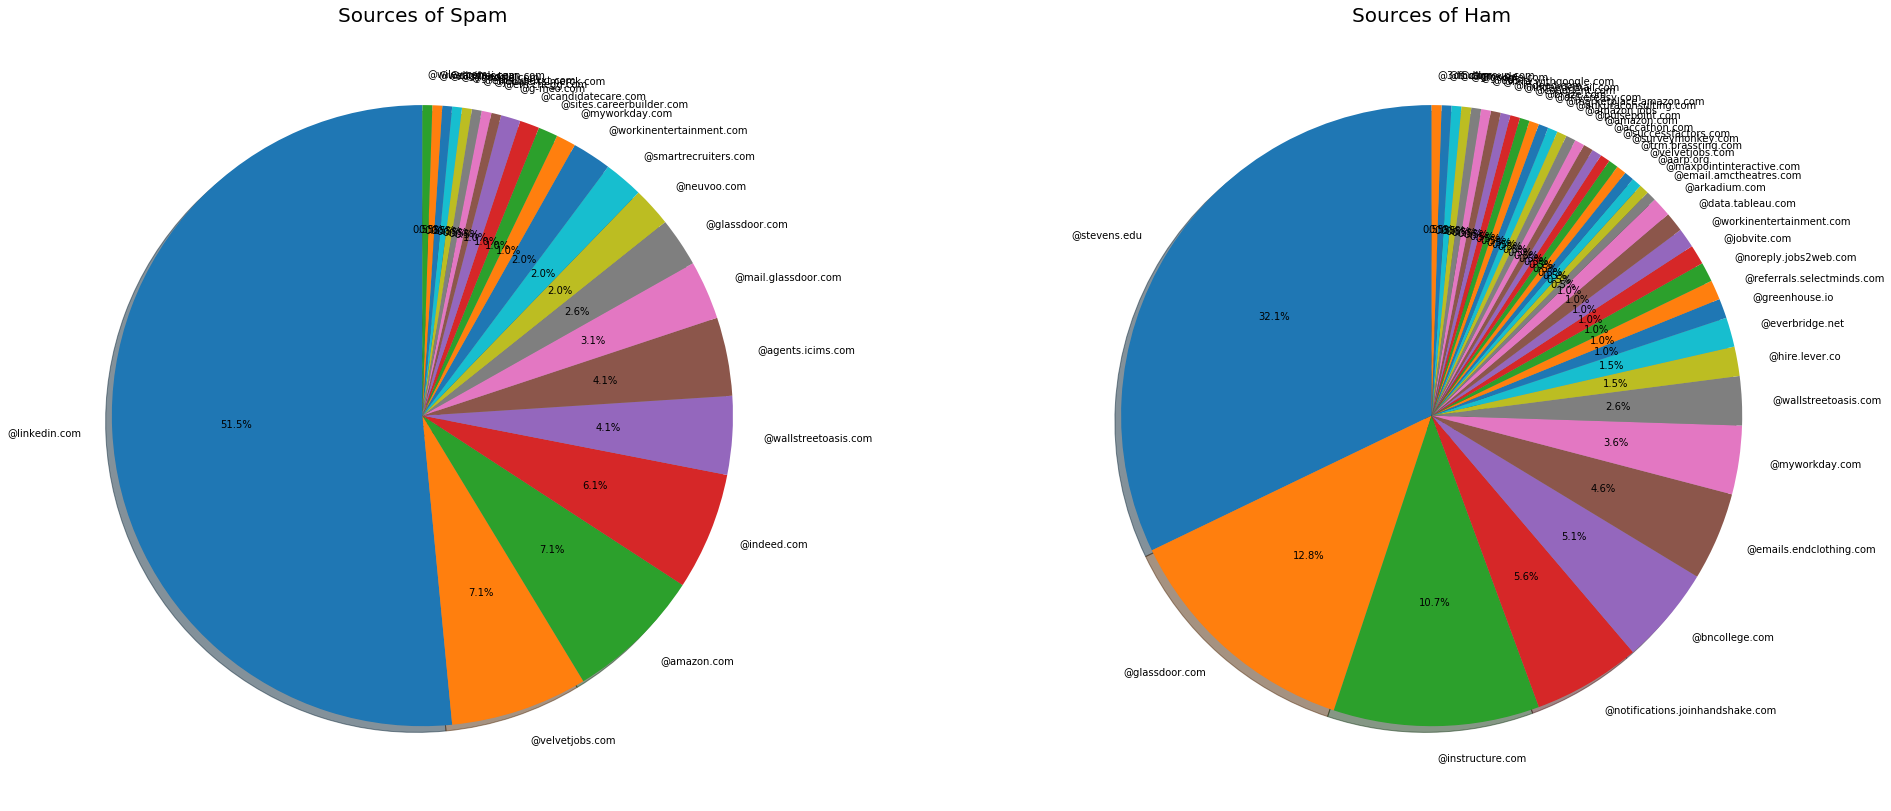

In [24]:
pie_word(df_ham,df_spam,'suffix','spam')

In [25]:
word_catogory = catogory_count(count_s.keys(),count_s.values(),count_h.keys(),count_h.values())
#All of word sorted
all_word = sort_word(word_catogory)
# Spam word sorted
spam_word = sort_word(word_catogory,True)
# Ham word sorted
ham_word = sort_word(word_catogory,False)

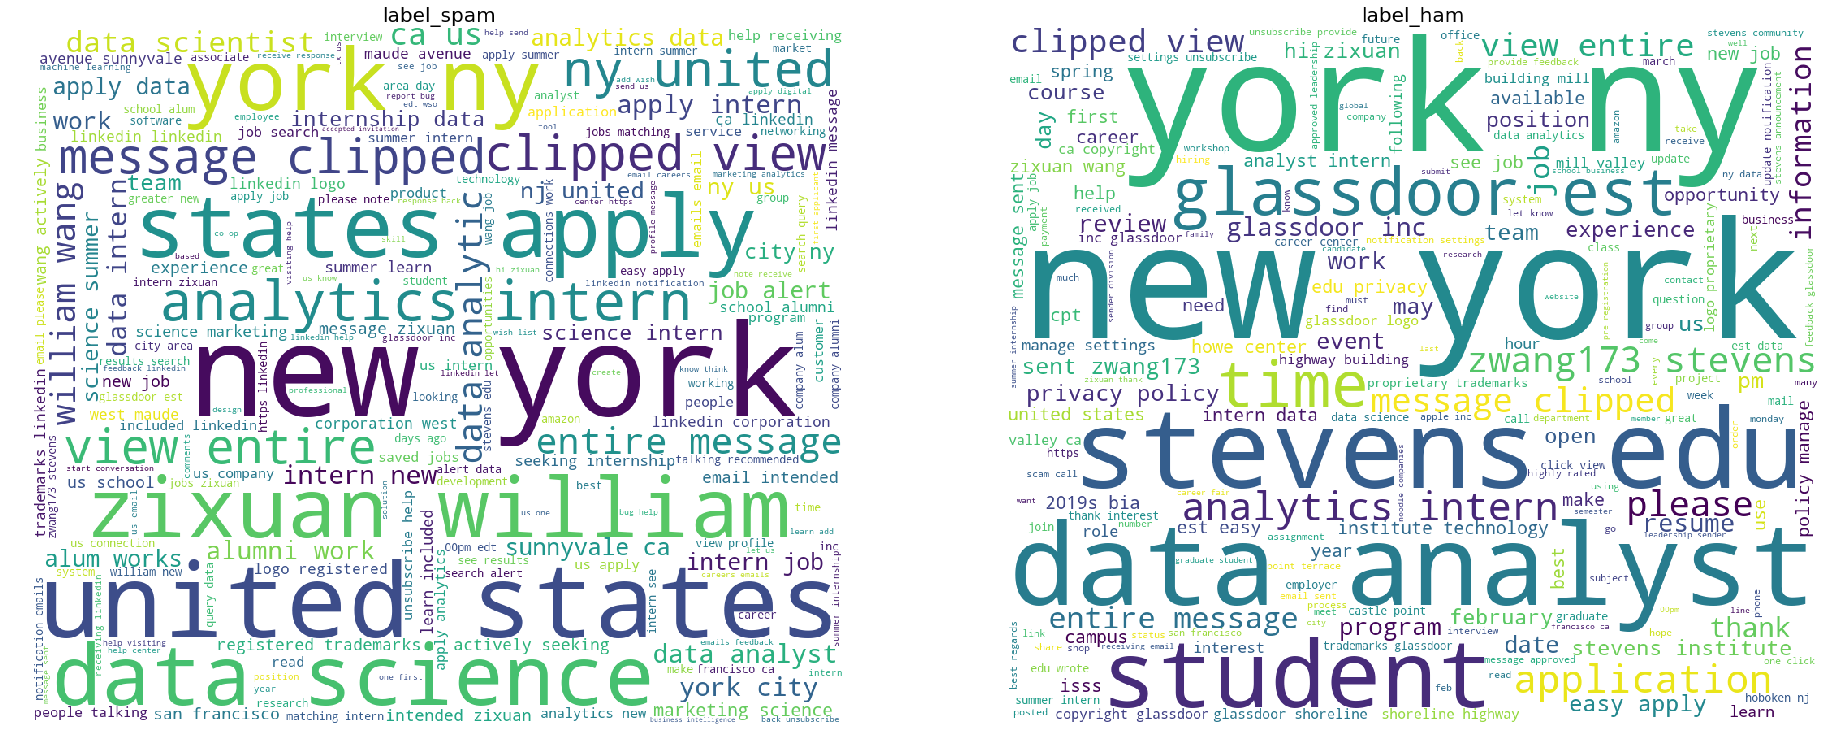

In [188]:
wordcloud_word(text_spam,text_ham)

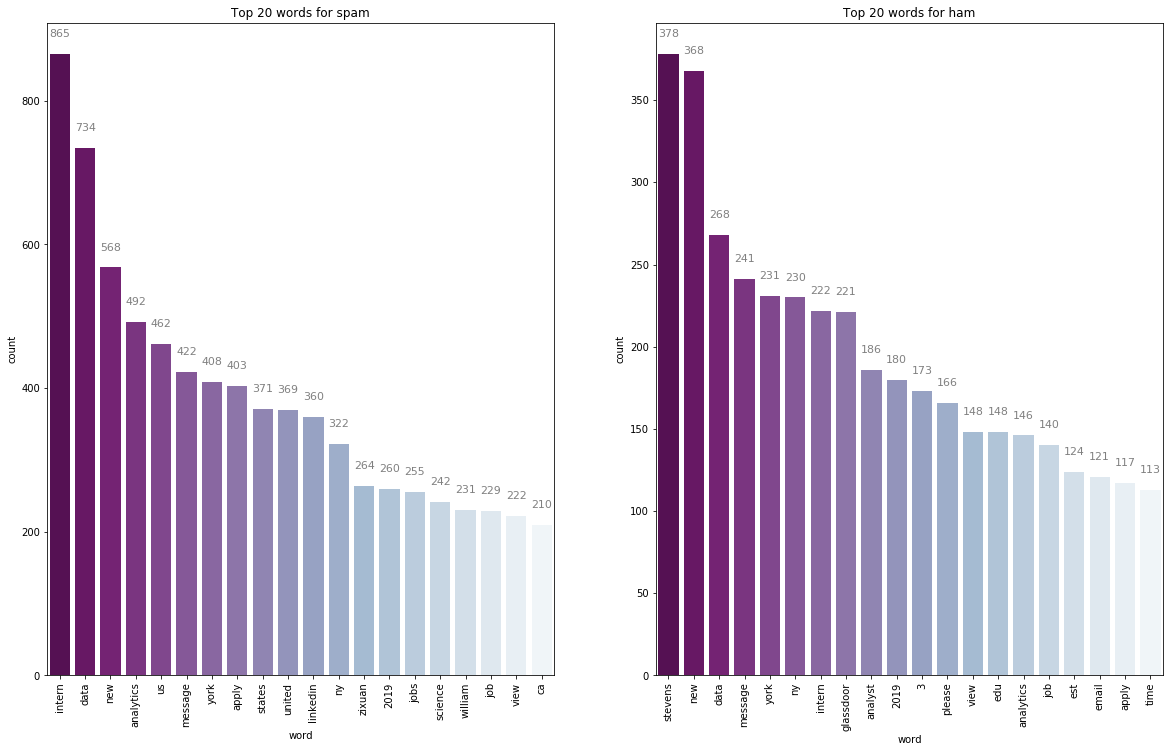

In [189]:
barplot_word(ham_word,spam_word)

- Remove same words in spam and ham

In [190]:
for i in range(len(data_s)):
    data_h[i] = re.sub(r'\b(new|ny|data|york|job|jobs|data|view|2019|zixuan|wang|work|message)\b', '', data_h[i])
    data_s[i] = re.sub(r'\b(new|ny|data|york|job|jobs|data|view|2019|zixuan|wang|work|message)\b', '', data_s[i]) 
word_s = text_lst(data_s, lemma = False, stopword = True)
word_h = text_lst(data_h, lemma = False, stopword = True)
count_s = count(word_s)
count_h = count(word_h)
word_catogory = catogory_count(count_s.keys(),count_s.values(),count_h.keys(),count_h.values())
#All of word sorted
all_word = sort_word(word_catogory)
# Spam word sorted
spam_word = sort_word(word_catogory,True)
# Ham word sorted
ham_word = sort_word(word_catogory,False)

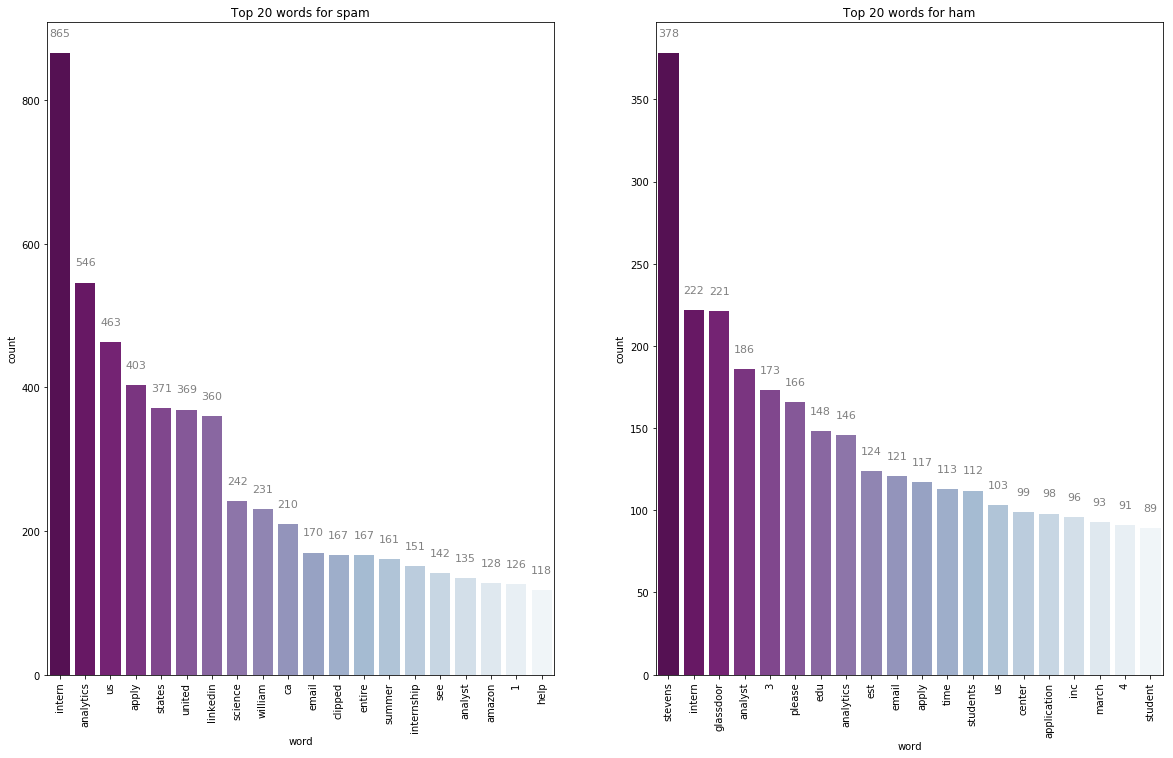

In [191]:
barplot_word(ham_word,spam_word)

In [194]:
text_spam = re.sub(r'\b(new|ny|data|york|job|jobs|data|view|2019|zixuan|wang|work|message)\b', '', text_spam)
text_ham = re.sub(r'\b(new|ny|data|york|job|jobs|data|view|2019|zixuan|wang|work|message)\b', '', text_ham)

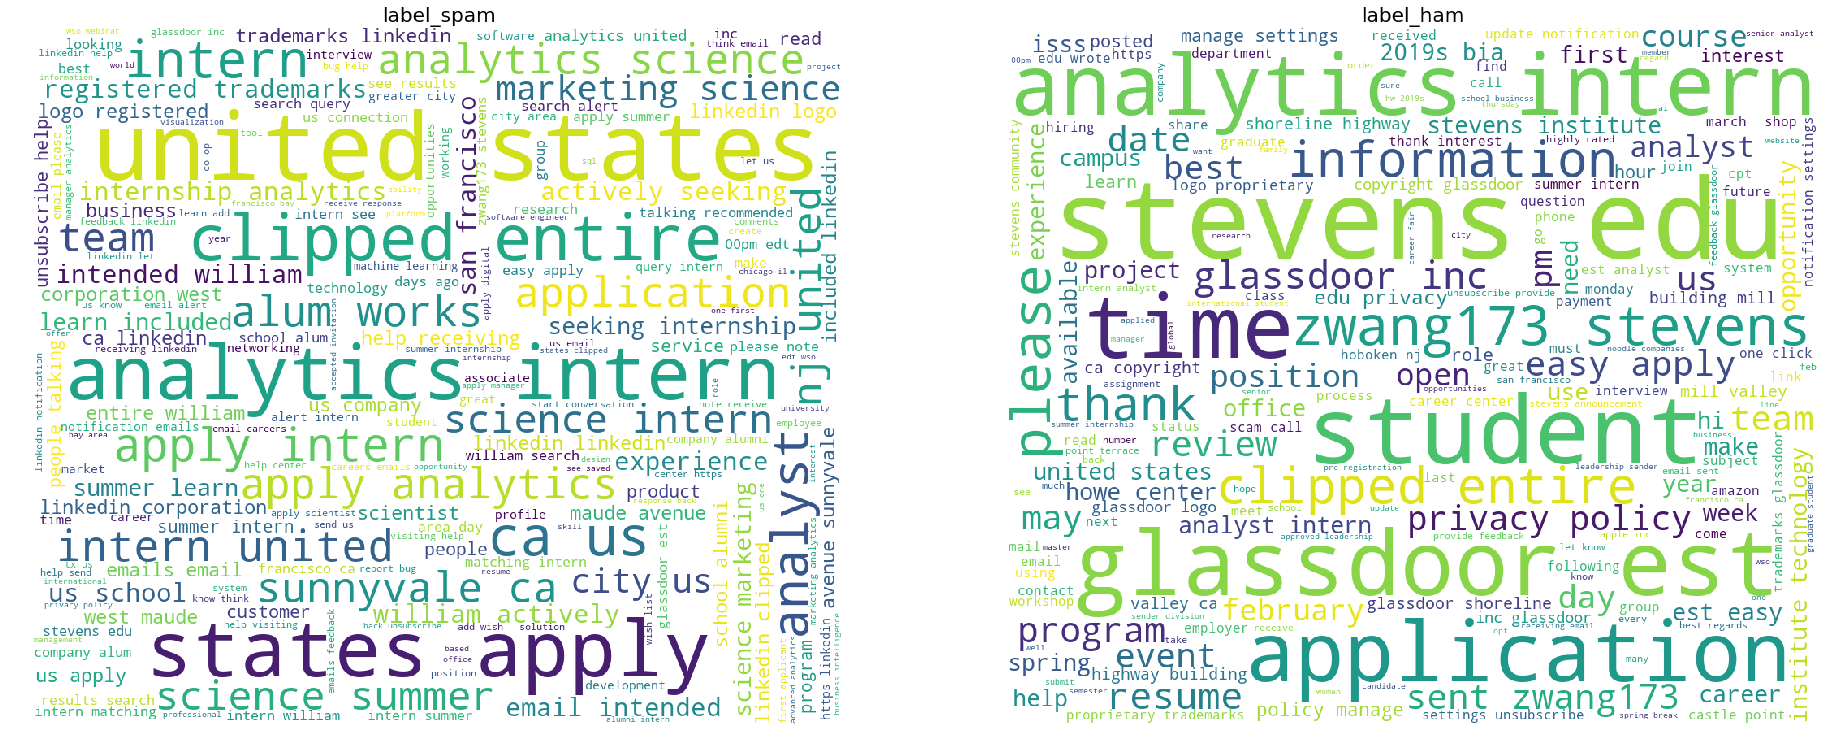

In [195]:
wordcloud_word(text_spam,text_ham)

- Analyze emails without '@linkedin.com'

In [200]:
df = df[df.suffix != '@linkedin.com']
idx_rdm_ham = random.sample(list(df[df.spam == 0].index),196)
idx_rdm_ham.sort()
df_ham = df.loc[idx_rdm_ham,]
df_spam = df[df.spam == 1]
data_title_s = list(df_spam[df_spam.spam == 1].title)
data_content_s = list(df_spam[df_spam.spam == 1].content)
data_title_h = list(df_ham[df_ham.spam == 0].title)
data_content_h = list(df_ham[df_ham.spam == 0].content)
# data_title_s = [x[2] for x in data_s]
# data_content_s = [x[3] for x in data_s]
# data_title_h = [x[2] for x in data_h]
# data_content_h = [x[3] for x in data_h]
# data_s = [x + ' ' + y for x,y in zip(data_title_s,data_content_s)]
# data_h = [x + ' ' + y for x,y in zip(data_title_h,data_content_h)]
sample_content_s = [tokenize(x,lemma = False, stopword = True) for x in data_content_s]
sample_content_h = [tokenize(x,lemma = False, stopword = True) for x in data_content_h]
sample_title_s = [tokenize(x,lemma = False, stopword = True) for x in data_title_s]
sample_title_h = [tokenize(x,lemma = False, stopword = True) for x in data_title_h]
sample_s = [x + y for x,y in zip(sample_title_s,sample_content_s)]
sample_h = [x + y for x,y in zip(sample_title_h,sample_content_h)]
data_s = [' '.join(i) for i in sample_s]
data_h = [' '.join(i) for i in sample_h]
text_spam = ' '.join([' '.join(i) for i in sample_s])
text_ham = ' '.join([' '.join(i) for i in sample_h])
# title_word_s = text_lst(data_title_s)
# content_word_s = text_lst(data_content_s)
# title_word_h = text_lst(data_title_h)
# content_word_h = text_lst(data_content_h)
# word_s = text_lst(data_s, lemma = False, stopword = True)
# word_h = text_lst(data_h, lemma = False, stopword = True)
# title_count_s = count(title_word_s)
# content_count_s = count(content_word_s)
# title_count_h = count(title_word_h)
# content_count_h = count(content_word_h)
# count_s = count(word_s)
# count_h = count(word_h)

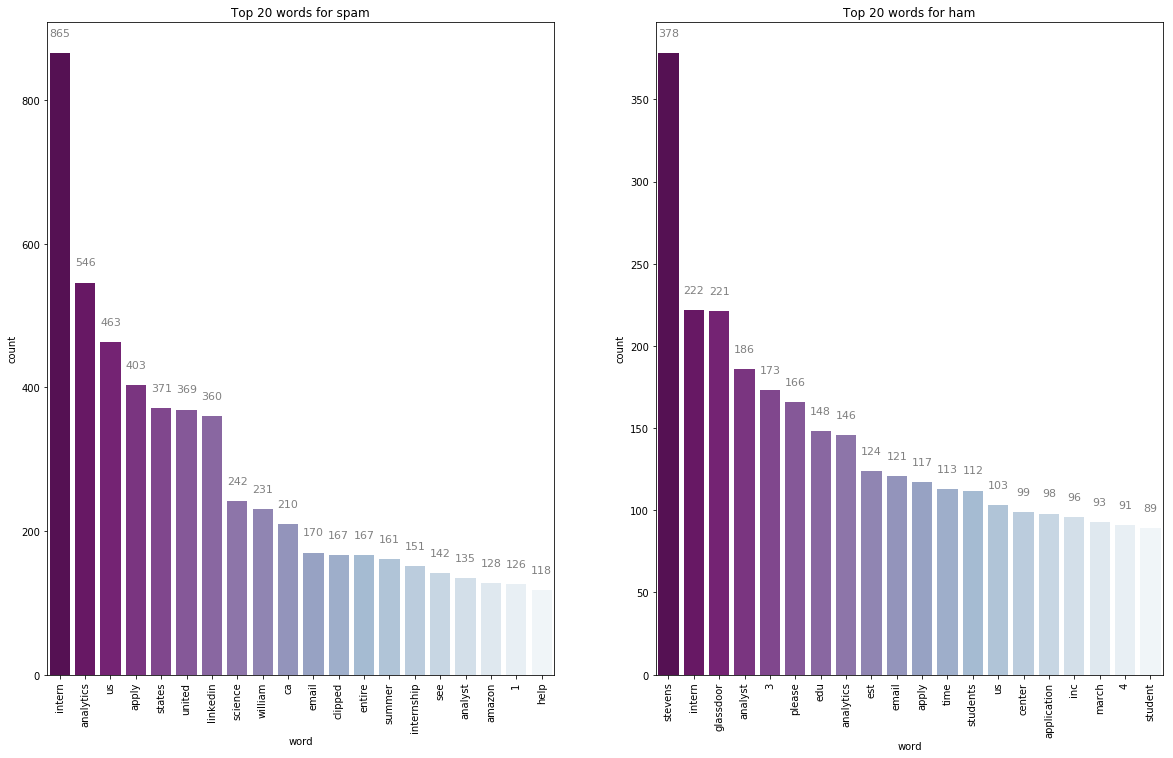

In [201]:
barplot_word(ham_word,spam_word)

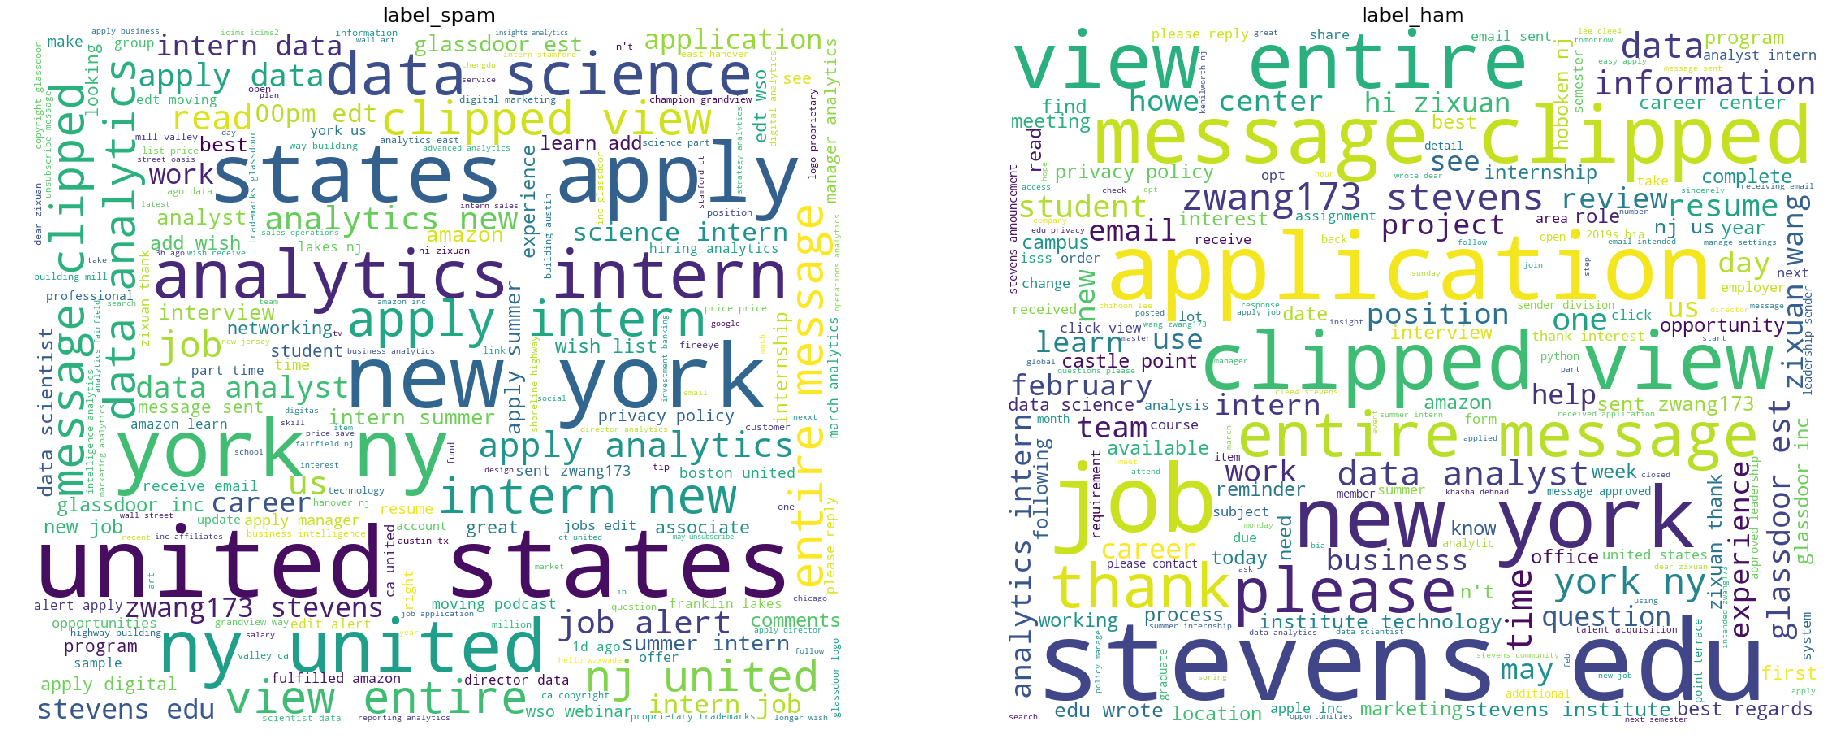

In [202]:
wordcloud_word(text_spam,text_ham)

# 4. Clustering
- Try to find the perference of individual and compare perfernce within different people
- Create label manually to judge if clustering analysis is accurate
- Build topic model to show the top words for each cluster

In [23]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation

In [26]:
df = pd.read_csv(r'C:\Users\wzxwa\Desktop\660\data\df_wzx.csv').set_index('index')
df['suffix'] = [re.findall(r'@[\w.|-]+',i)[0] for i in df.address]

In [27]:
df_ham = df[df.spam == 0]
df_spam = df[df.spam == 1]
data_title_s = list(df_spam[df_spam.spam == 1].title)
data_content_s = list(df_spam[df_spam.spam == 1].content)
data_title_h = list(df_ham[df_ham.spam == 0].title)
data_content_h = list(df_ham[df_ham.spam == 0].content)
# data_title_s = [x[2] for x in data_s]
# data_content_s = [x[3] for x in data_s]
# data_title_h = [x[2] for x in data_h]
# data_content_h = [x[3] for x in data_h]
# data_s = [x + ' ' + y for x,y in zip(data_title_s,data_content_s)]
# data_h = [x + ' ' + y for x,y in zip(data_title_h,data_content_h)]
sample_content_s = [tokenize(x,lemma = False, stopword = True) for x in data_content_s]
sample_content_h = [tokenize(x,lemma = False, stopword = True) for x in data_content_h]
sample_title_s = [tokenize(x,lemma = False, stopword = True) for x in data_title_s]
sample_title_h = [tokenize(x,lemma = False, stopword = True) for x in data_title_h]
sample_s = [x + y for x,y in zip(sample_title_s,sample_content_s)]
sample_h = [x + y for x,y in zip(sample_title_h,sample_content_h)]
data_s_t = [' '.join(i) for i in sample_title_s]
data_h_t = [' '.join(i) for i in sample_title_h]
data_s_c = [' '.join(i) for i in sample_content_s]
data_h_c = [' '.join(i) for i in sample_content_h]
data_s = [' '.join(i) for i in sample_s]
data_h = [' '.join(i) for i in sample_h]
text_spam = ' '.join([' '.join(i) for i in sample_s])
text_ham = ' '.join([' '.join(i) for i in sample_h])
# title_word_s = text_lst(data_title_s)
# content_word_s = text_lst(data_content_s)
# title_word_h = text_lst(data_title_h)
# content_word_h = text_lst(data_content_h)
word_s = text_lst(data_s, lemma = False, stopword = True)
word_h = text_lst(data_h, lemma = False, stopword = True)
# title_count_s = count(title_word_s)
# content_count_s = count(content_word_s)
# title_count_h = count(title_word_h)
# content_count_h = count(content_word_h)
count_s = count(word_s)
count_h = count(word_h)

In [26]:
df_ham.loc[:,'title'] = data_h_t
df_ham.loc[:,'content'] = data_h_c
df_spam.loc[:,'title'] = data_s_t
df_spam.loc[:,'content'] = data_s_c

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [28]:
# Dataframe, the perportion of ham and spam is 2.5:1
idx_rdm_ham = random.sample(list(df[df.spam == 0].index),500)
idx_rdm_ham.sort()
df_ham = df.loc[idx_rdm_ham,]
df = df_ham.append(df_spam)

In [29]:
#Scree plot
def elb_m(dtm):    
    d = []
    K = range(1,10)
    for k in K:

        kmean = KMeans(n_clusters=k,n_init=10).fit(dtm.toarray())
        kmean.fit(dtm.toarray())
        d.append(sum(np.min(cdist(dtm.toarray(), kmean.cluster_centers_, 'euclidean'), axis=1)) / dtm.toarray().shape[0])

    plt.plot(K, d, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method')
    plt.show()

In [33]:
tfidf_vect = TfidfVectorizer(stop_words="english") 
dtm = tfidf_vect.fit_transform(df_spam['content'])

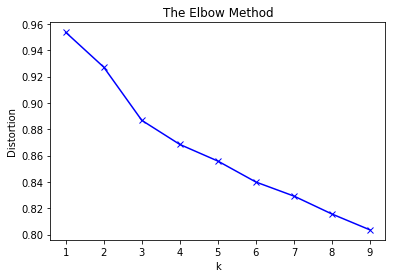

In [682]:
#spam elbow
elb_m(dtm)

In [91]:
from nltk.cluster import KMeansClusterer, \
cosine_distance
num_clusters=3

clusterer = KMeansClusterer(num_clusters, \
                            cosine_distance, \
                            repeats=20)

clusters = clusterer.cluster(dtm.toarray(), \
                             assign_clusters=True)

In [92]:
idx_1 = [idx for idx,i in enumerate(clusters) if i == 0]
idx_2 = [idx for idx,i in enumerate(clusters) if i == 1]
idx_3 = [idx for idx,i in enumerate(clusters) if i == 2]

In [76]:
df_spam = df_spam.reset_index()

In [105]:
#spam label
job = ['LinkedIn Job Alerts','LinkedIn','Indeed Job Alert','VelvetJobs','Indeed','Glassdoor News','Indeed Apply','Glassdoor Jobs','Your daily job aler.']
other = ['Amazon.com','Ancestry','CapitalOneHRWorkday','CareerBuilder','Digitas','FireEye, Inc.', 'FireEye, Inc. Hirin.',\
 'G-MEO China Study/I.','G-MEO Study Abroad','Glassdoor','Gulf States Financi.', 'MSD Human Resources','Nexxt',\
 'Noblis @ icims','Perspecta @ icims','Talent Acquisition','Thomas Benner','Wiley Recruitment T.','WorkInEntertainment.',\
 'auto-confirm@amazon.com','chrome@indeed.com','customer-re...@amazon.com','dpoler@syr.edu','mariana@wearehei.com',\
 'marketplace...@amazon.com','mcafee@myworkday.com','no-reply@digitaloce.','secumd+autoreply@ag.','store-news@amazon.com',\
 'vfe-campaig...@amazon.com','yr+autoreply@agents.']
add = list(set(df_spam.name.unique())-(set(job)|set(other)))
lst_cate = []
for i in df[df.spam==1].name:
    if i in job:
        lst_cate.append('job')
    elif i in add:
        lst_cate.append('add')
    else:
        lst_cate.append('other')
df_spam['category'] = lst_cate

In [100]:
df_spam.loc[idx_2,:].name.unique()

array(['Wall Street Oasis', 'auto-confirm@amazon.com',
       'palmai@google.com', 'CareerBuilder', 'Indeed Job Alert',
       'mariana@wearehei.com', 'G-MEO China Study/I.', 'Amazon.com',
       'vfe-campaig...@amazon.com', 'yr+autoreply@agents.', 'Indeed',
       'Nexxt', 'chrome@indeed.com', 'customer-re...@amazon.com',
       'Perspecta @ icims', 'Thomas Benner', 'Indeed Apply',
       'WorkInEntertainment.', 'Noblis @ icims', 'Patrick Curtis',
       'store-news@amazon.com', 'no-reply@digitaloce.',
       'marketplace...@amazon.com', 'Digitas', 'MSD Human Resources',
       'mcafee@myworkday.com', 'Ancestry', 'secumd+autoreply@ag.',
       'FireEye, Inc. Hirin.', 'Talent Acquisition', 'dpoler@syr.edu',
       'FireEye, Inc.', 'CapitalOneHRWorkday', 'Gulf States Financi.',
       'Wiley Recruitment T.'], dtype=object)

In [106]:
spam_train, spam_test = train_test_split(df_spam[df_spam.spam == 1], test_size=0.3, random_state=0)
tfidf_vect = TfidfVectorizer(stop_words="english") 
dtm= tfidf_vect.fit_transform(df_spam['content'])

In [108]:
#spam confusion matrix
#add is those connection emails from LinkedIn
test_dtm = tfidf_vect.transform(spam_test['content'])
predicted = [clusterer.classify(v) for v in test_dtm.toarray()]
confusion_df = pd.DataFrame(list(zip(spam_test.category, predicted)),\
                            columns = ["category", "cluster"])
print(pd.crosstab(index=confusion_df.cluster, columns=confusion_df.category))
from sklearn import metrics
cluster_dict={0:'job',\
              1:"other",\
              2:'add'}

# Map true label to cluster id
predicted_target=[cluster_dict[i] \
                  for i in predicted]

print(metrics.classification_report\
      (spam_test["category"], predicted_target))

category  add  job  other
cluster                  
0           0   20      1
1           2    2     15
2           9   10      0
              precision    recall  f1-score   support

         add       0.47      0.82      0.60        11
         job       0.95      0.62      0.75        32
       other       0.79      0.94      0.86        16

   micro avg       0.75      0.75      0.75        59
   macro avg       0.74      0.79      0.74        59
weighted avg       0.82      0.75      0.75        59



In [109]:
from sklearn.feature_extraction.text import CountVectorizer
tf_vectorizer = TfidfVectorizer(stop_words="english")
tf = tf_vectorizer.fit_transform(spam_train['content'])
tf_feature_names = tf_vectorizer.get_feature_names()
X_train, X_test = train_test_split(\
                tf, test_size=0.3, random_state=0)
lda = LatentDirichletAllocation(n_components=3, \
                                max_iter=20,verbose=1,
                                evaluate_every=1, n_jobs=1,
                                random_state=0).fit(X_train)

iteration: 1 of max_iter: 20, perplexity: 14589.9522
iteration: 2 of max_iter: 20, perplexity: 13968.2350
iteration: 3 of max_iter: 20, perplexity: 13623.3684
iteration: 4 of max_iter: 20, perplexity: 13309.1267
iteration: 5 of max_iter: 20, perplexity: 12934.0353
iteration: 6 of max_iter: 20, perplexity: 12542.2762
iteration: 7 of max_iter: 20, perplexity: 12295.3996
iteration: 8 of max_iter: 20, perplexity: 12079.9671
iteration: 9 of max_iter: 20, perplexity: 11751.9374
iteration: 10 of max_iter: 20, perplexity: 11371.4201
iteration: 11 of max_iter: 20, perplexity: 11297.6371
iteration: 12 of max_iter: 20, perplexity: 11226.8204
iteration: 13 of max_iter: 20, perplexity: 11174.2827
iteration: 14 of max_iter: 20, perplexity: 11160.5074
iteration: 15 of max_iter: 20, perplexity: 11139.6841
iteration: 16 of max_iter: 20, perplexity: 11138.3372
iteration: 17 of max_iter: 20, perplexity: 11135.4428
iteration: 18 of max_iter: 20, perplexity: 11121.6143
iteration: 19 of max_iter: 20, perple

In [111]:
# spam top word
num_top_words=20

for topic_idx, topic in enumerate(lda.components_):
    print ("Topic %d:" % (topic_idx))
    # print out top 20 words per topic 
    words=[(tf_feature_names[i],topic[i]) \
           for i in topic.argsort()[::-1][0:num_top_words]]
    print(words)
    print("\n")

Topic 0:
[('intern', 11.327644734042973), ('linkedin', 7.801811723502713), ('data', 7.7326260404263945), ('new', 5.941052107517547), ('york', 5.732626230010133), ('analytics', 5.25169777571374), ('apply', 4.885571971166263), ('ny', 4.645410450243094), ('message', 4.410746611608455), ('united', 4.366844549505728), ('states', 4.323784163868942), ('science', 4.178983328932055), ('2019', 3.8810660138804414), ('ca', 3.830146379887099), ('glassdoor', 3.79899687088459), ('jobs', 3.5209950464532285), ('ago', 3.480099319555941), ('william', 3.46046876013701), ('work', 3.39185240593038), ('zixuan', 3.1983583082682037)]


Topic 1:
[('null', 1.1410495978615884), ('link', 0.9080714970617143), ('wiley', 0.8171717468446679), ('02', 0.7777805810970249), ('1628', 0.7041653826178635), ('single', 0.6343318519736625), ('complete', 0.6215754982700405), ('candidate', 0.5904556244745298), ('click', 0.5784483305283992), ('16', 0.5342283993454063), ('3deml', 0.5213405774722123), ('ayj6gr', 0.5213405774722123),

In [63]:
#ham label
job = ['@glassdoor.com','@indeed.com','@notifications.joinhandshake.com','@jobvite.com',\
'@workinentertainment.com','@indeed.com','@referrals.selectminds.com','@mail.amazon.jobs','@g-meo.com',\
       '@linkedin.com','@mail.joinhandshake.com','@amazon.jobs','@campaigns.jobs2web.com',\
       '@myworkday.com','@greenhouse.io','@hire.lever.co','@noreply.jobs2web.com','@trm.brassring.com',\
'@successfactors.com','@myworkday.com','@applytojob.com','@candidates.workablemail.com','@hire.withgoogle.com',\
'@invalidemail.com','@applicantemail.com','@inmail.application.jobs','@agents.icims.com','@indeedemail.com',\
             '@peoplefluent.com','@bertelsmann-hr.de']
schoolwork = ['@everbridge.net','@stevens.edu','@instructure.com','@bncollege.com']

lst_cate = []
for i in df[df.spam==0].suffix:
    if i in job:
        lst_cate.append('job')
    elif i in schoolwork:
        lst_cate.append('schoolwork')
    else:
        lst_cate.append('other')
df_ham['category'] = lst_cate

In [ ]:
tfidf_vect = TfidfVectorizer(stop_words="english") 
dtm= tfidf_vect.fit_transform(df_ham['content'])

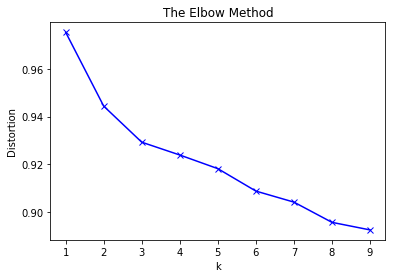

In [503]:
#ham elbow
elb_m(dtm)

In [640]:
ham_train, ham_test = train_test_split(df_ham[df_ham.spam == 0], test_size=0.3, random_state=0)
tfidf_vect = TfidfVectorizer(stop_words="english") 
dtm= tfidf_vect.fit_transform(ham_train['content'])

In [593]:
from nltk.cluster import KMeansClusterer, \
cosine_distance

num_clusters=3

clusterer = KMeansClusterer(num_clusters, \
                            cosine_distance, \
                            repeats=20)

clusters = clusterer.cluster(dtm.toarray(), \
                             assign_clusters=True)

In [557]:
# idx_1 = [idx for idx,i in enumerate(clusters) if i == 0]
# idx_2 = [idx for idx,i in enumerate(clusters) if i == 1]
# idx_3 = [idx for idx,i in enumerate(clusters) if i == 2]

In [564]:
df_ham = df_ham.reset_index()

In [622]:
#ham confusion matrix
test_dtm = tfidf_vect.transform(ham_test['content'])
predicted = [clusterer.classify(v) for v in test_dtm.toarray()]
confusion_df = pd.DataFrame(list(zip(ham_test.category, predicted)),\
                            columns = ["category", "cluster"])
print(pd.crosstab(index=confusion_df.cluster, columns=confusion_df.category))
from sklearn import metrics
cluster_dict={0:'other',\
              1:"job",\
              2:'schoolwork'}

# Map true label to cluster id
predicted_target=[cluster_dict[i] \
                  for i in predicted]

print(metrics.classification_report\
      (ham_test["category"], predicted_target))

category  job  other  schoolwork
cluster                         
0          18     23          16
1          34      5           0
2           3      6          45
              precision    recall  f1-score   support

         job       0.87      0.62      0.72        55
       other       0.40      0.68      0.51        34
  schoolwork       0.83      0.74      0.78        61

   micro avg       0.68      0.68      0.68       150
   macro avg       0.70      0.68      0.67       150
weighted avg       0.75      0.68      0.70       150



In [653]:
from sklearn.feature_extraction.text import CountVectorizer
tf_vectorizer = TfidfVectorizer(stop_words="english")
tf = tf_vectorizer.fit_transform(ham_train['content'])
tf_feature_names = tf_vectorizer.get_feature_names()
X_train, X_test = train_test_split(\
                tf, test_size=0.3, random_state=0)
lda = LatentDirichletAllocation(n_components=3, \
                                max_iter=20,verbose=1,
                                evaluate_every=1, n_jobs=1,
                                random_state=0).fit(X_train)

In [656]:
#ham top words
num_top_words=20

for topic_idx, topic in enumerate(lda.components_):
    print ("Topic %d:" % (topic_idx))
    # print out top 20 words per topic 
    words=[(tf_feature_names[i],topic[i]) \
           for i in topic.argsort()[::-1][0:num_top_words]]
    print(words)
    print("\n")

Topic 0:
[('glassdoor', 12.400475622154692), ('new', 10.02961550074864), ('data', 9.534216344496743), ('ny', 8.73857154222703), ('analyst', 8.061029313231396), ('york', 8.022614217238292), ('job', 6.805822762963337), ('intern', 6.788192525425906), ('est', 6.362606427752267), ('apply', 5.411538887031905), ('analytics', 4.728283198859138), ('jobs', 4.190284531161339), ('application', 4.1093479497636896), ('com', 4.070594497415964), ('nj', 3.8664442254556364), ('apple', 3.781536021882984), ('email', 3.732369665031888), ('zixuan', 3.573996507089095), ('message', 3.500042184788332), ('ca', 3.3828562014678)]


Topic 1:
[('stevens', 5.721558510186617), ('march', 4.318221279433179), ('2019', 4.302129259326182), ('center', 3.820750098366599), ('00', 3.638604238869903), ('message', 3.242754523762494), ('campus', 3.082256596215639), ('update', 3.039404865633622), ('project', 2.940362454390509), ('february', 2.9369253120190857), ('howe', 2.8628058439552415), ('chihoon', 2.698460457668909), ('notif

# 5. Classification
- Use cross validation to assess and balance data
- Different classifiers (LDA,LR,MultiNB,SVM,ensemble) to predict spam

In [538]:
def MultiNB(df_train,df_test):
    text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                         ('clf', MultinomialNB())
                       ])

    parameters = {'tfidf__min_df':[1, 2, 3],
                  'tfidf__stop_words':[None,"english"],
                  'clf__alpha': [0.5,1.0,2.0],}

    metric =  "f1_macro"

    gs_clf = GridSearchCV\
    (text_clf, param_grid=parameters, \
     scoring=metric, cv=5)

    gs_clf = gs_clf.fit(df_train["title"], df_train["spam"])
    
    print('The best parameters:')
    for param_name in gs_clf.best_params_:
        print(param_name,": ", gs_clf.best_params_[param_name])
    print("best f1 score:", gs_clf.best_score_)
    
    labels = sorted(df_train["spam"].unique())
    predicted = gs_clf.predict(df_test["title"])
    precision, recall, fscore, support=\
    precision_recall_fscore_support(\
     df_test["spam"], predicted, labels = labels)

    print(classification_report\
      (np.array(df_test["spam"]), predicted))
    
    predicted_prob_2 = [i[1] for i in gs_clf.predict_proba(df_test["title"])]
    fpr, tpr, thresholds = roc_curve(df_test["spam"], predicted_prob_2, \
                                 pos_label=1)
    print("AUC score:", auc(fpr, tpr))
    plt.figure();
    plt.plot(fpr, tpr, color='darkorange', lw=2, label = 'AUC = %0.2f' % auc(fpr, tpr));
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.05]);
    plt.legend(loc = 'lower right')
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate');
    plt.title('AUC of Naive Bayes Model');
    plt.show();
    

    precision_prob, recall_prob, thresholds = precision_recall_curve(df_test["spam"], \
                                predicted_prob_2, pos_label=1)
    plt.figure();
    plt.plot(recall_prob, precision_prob, color='darkorange', lw=2);
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.05]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    plt.title('Precision_Recall_Curve of Naive Bayes Model');
    plt.show();

In [536]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=0)

The best parameters:
clf__alpha :  0.5
tfidf__min_df :  3
tfidf__stop_words :  None
best f1 score: 0.8798011409591878
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       155
           1       0.86      0.70      0.78        54

   micro avg       0.89      0.89      0.89       209
   macro avg       0.88      0.83      0.85       209
weighted avg       0.89      0.89      0.89       209

AUC score: 0.9506571087216248


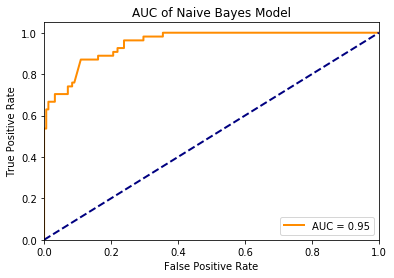

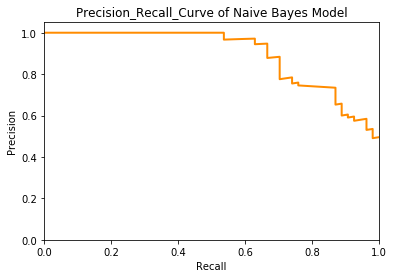

In [539]:
classify(df_train,df_test)

In [65]:
def svm_df(df_X,df_Y):
    
    tfidf_vect = TfidfVectorizer() 
    dtm= tfidf_vect.fit_transform(df_X)
    X_train, X_test, y_train, y_test = train_test_split(\
                    dtm, df_Y, test_size=0.3, random_state=0) 

    classifier = svm.SVC(kernel='linear', probability=True)
    predicted = classifier.fit(X_train, y_train).predict(X_test)
    labels=sorted(df_Y.unique())
    precision, recall, fscore, support=precision_recall_fscore_support(y_test, predicted, labels=labels)
    print(classification_report\
      ([str(i) for i in y_test], [str(i) for i in predicted], target_names=[str(i) for i in labels]))

    probas_1 = [i[1] for i in classifier.fit(X_train, y_train).predict_proba(X_test)]
    fpr, tpr, thresholds = roc_curve([str(i) for i in y_test], probas_1, \
                                 pos_label='1')
    
    print("AUC score:", auc(fpr, tpr))
    plt.figure();
    plt.plot(fpr, tpr, color='darkorange', lw=2, label = 'AUC = %0.2f' % auc(fpr, tpr));
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.05]);
    plt.legend(loc = 'lower right')
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate');
    plt.title('AUC of SVM Model_title');
    plt.show();

    precision_prob, recall_prob, thresholds = precision_recall_curve([str(i) for i in y_test], \
                                probas_1, pos_label='1')
    plt.figure();
    plt.plot(recall_prob, precision_prob, color='darkorange', lw=2);
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.05]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    plt.title('Precision_Recall_Curve of SVM Model_title');
    plt.show();

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       155
           1       0.91      0.78      0.84        54

   micro avg       0.92      0.92      0.92       209
   macro avg       0.92      0.88      0.89       209
weighted avg       0.92      0.92      0.92       209

AUC score: 0.9364396654719235


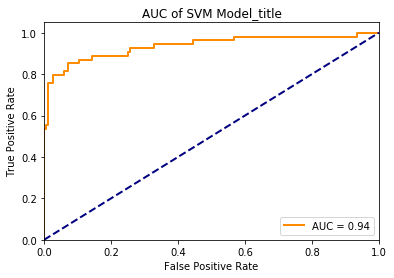

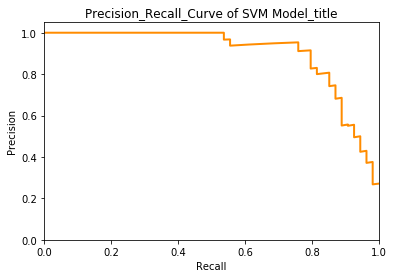

In [66]:
svm_df(df['content'],df['spam'])

In [ ]:
tfidf_vect = TfidfVectorizer() 
dtm= tfidf_vect.fit_transform(df_X)
X_train, X_test, y_train, y_test = train_test_split(\
                dtm, df_Y, test_size=0.3, random_state=0)

LDA = LinearDiscriminantAnalysis()
LR = LogisticRegression()
KNN = KNeighborsClassifier()
NB = GaussianNB()
MNB = MultinomialNB()

# MNB
MNB = MultinomialNB()
MNB.fit(X_train, y_train)
MNB_score = MNB.score(X_test, y_test)
print(MNB_score)
MNB_probs = MNB.predict_proba(X_test)
MNB_probs = MNB_probs[:, 1]
print(MNB_probs)
MNB_auc = roc_auc_score(y_test, MNB_probs)
MNB_auc = round(MNB_auc, 4)
print(MNB_auc)

MNB_fpr, MNB_tpr, thresholds = roc_curve(y_test, MNB_probs, pos_label=1)


# LDA
print('\nLDA Classifier')
LDA = LinearDiscriminantAnalysis()
LDA = LDA.fit(X_train, y_train)
LDA_score = LDA.score(X_test, y_test)
# print(LDA_score)
LDA_probs = LDA.predict_proba(X_test)
LDA_probs = LDA_probs[:, 1]
LDA_auc = roc_auc_score(y_test, LDA_probs)
LDA_auc = round(LDA_auc, 4)
print(LDA_auc)

LDA_fpr, LDA_tpr, thresholds = roc_curve(y_test, LDA_probs, pos_label=1)

# LR
print('\nLR Classifier')
LR = LogisticRegression(solver='lbfgs', max_iter=5000)
LR = LR.fit(X_train, y_train)
LR_score = LR.score(X_test, y_test)
# print(LR_score)
LR_probs = LR.predict_proba(X_test)
LR_probs = LR_probs[:, 1]
# print(probs)
LR_auc = roc_auc_score(y_test, LR_probs)
print(LR_auc)
LR_auc = round(LR_auc, 4)
print(LR_auc)

LR_fpr, LR_tpr, thresholds = roc_curve(y_test, LR_probs, pos_label=1)


# SVM
print('\nSVM Classifier')
SVM = svm.SVC(kernel='rbf', probability=True)
SVM = SVM.fit(X_train, y_train)
SVM_score = SVM.score(X_test, y_test)
# print(SVM_score)
SVM_probs = SVM.predict_proba(X_test)
SVM_probs = SVM_probs[:, 1]
# print(SVM_probs)
SVM_auc = roc_auc_score(y_test, SVM_probs)
SVM_auc = round(SVM_auc, 4)
print(SVM_auc)

SVM_fpr, SVM_tpr, thresholds = roc_curve(y_test, SVM_probs, pos_label=1)


# NB
print('\nNB Classifier')
NB = GaussianNB()
NB = NB.fit(X_train, y_train)
NB_score = NB.score(X_test, y_test)
# print(NB_score)
NB_probs = NB.predict_proba(X_test)
NB_probs = NB_probs[:, 1]
# print(NB_probs)
NB_auc = roc_auc_score(y_test, NB_probs)
NB_auc = round(NB_auc, 4)
print(NB_auc)

NB_fpr, NB_tpr, thresholds = roc_curve(y_test, NB_probs, pos_label=1)

# models plot
plt.plot(LDA_fpr, LDA_tpr, color='orange', label='LDA_AUC = {}'.format(LDA_auc))
plt.plot(LR_fpr, LR_tpr, color='red', label='LR_AUC = {}'.format(LR_auc))
plt.plot(SVM_fpr, SVM_tpr, color='green', label='SVM_AUC = {}'.format(SVM_auc))
plt.plot(NB_fpr, NB_tpr, color='blue', label='NB_AUC = {}'.format(NB_auc))
plt.plot(MNB_fpr, MNB_tpr, color='black', label='MNB_AUC = {}'.format(MNB_auc))
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Ensemble
print('\n\n')
estimator = [('NB', NB), ('LR', LR), ('LDA', LDA), ('SVM', SVM), ('MNB', MNB)]
ensemble = VotingClassifier(estimator, voting='soft')
ensemble = ensemble.fit(X_train, y_train)
ensemble_score = ensemble.score(X_test, y_test)
print(ensemble_score)
ensemble_probs = ensemble.predict_proba(X_test)
ensemble_probs = ensemble_probs[:, 1]
# print(NB_probs)
ensemble_auc = roc_auc_score(y_test, ensemble_probs)
print(ensemble_auc)
ensemble_auc = round(ensemble_auc, 4)
print(ensemble_auc)

ensemble_fpr, ensemble_tpr, thresholds = roc_curve(y_test, ensemble_probs, pos_label=1)

# ensemble model plot
plt.plot(ensemble_fpr, ensemble_tpr, color='orange', label='ensemble_AUC = {}'.format(ensemble_auc))
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()